In [58]:
from keras.models import Sequential
from keras.layers import Dense
import cv2
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

In [59]:
path = "myData"
labelFile = 'labels.csv'
batch_size_val = 50
steps_per_epoch_val = 1000
epochs_val = 3
imageDimension = (32, 32, 3)
testRatio = 0.2
validationRatio = 0.2

# Importing Images

In [60]:
count = 0
images = []
classno = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noofclasses = len(myList)
random.shuffle(myList)
myList[0]
print("Importing Classes.....")

Total Classes Detected: 43
Importing Classes.....


In [61]:
for i in range (0,noofclasses):
    mydata = os.listdir(path + "/" + str(i))
    for j in mydata:
        curImg = cv2.imread(path + "/" + str(i) + "/" + j)
        curImg = cv2.resize(curImg,(32,32))
        images.append(curImg)
        classno.append(i)
    print(i, end = " ")
    i +=1
print(" ")
images = np.array(images)
classno = np.array(classno)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


# Splitting the Data

In [62]:
X_train, X_test, y_train, y_test = train_test_split(images, classno, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)


In [63]:
print("Data Shapes")
print("Train",end="");print(X_train.shape, y_test.shape)
print("Validation",end="");print(X_validation.shape, y_validation.shape)
print("Test",end="");print(X_test.shape, y_test.shape)


Data Shapes
Train(22271, 32, 32, 3) (6960,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [64]:
assert(X_train.shape[0] == y_train.shape[0]), "the number of images are not equal to the number of labels in train sets"
assert(X_validation.shape[0] == y_validation.shape[0]),"The number of images are not equal in validation set"
assert(X_test.shape[0] == y_test.shape[0]), "the number of images are not equal in test sets"
assert(X_train.shape[1:] == (imageDimension)), "the dimension of the training images are wrong"
assert(X_validation.shape[1:] == (imageDimension)), "the dimension of the validation images are wrong"
assert(X_test.shape[1:] == (imageDimension)), "the dimensions of the test images are wrong"


# Reading CSV FILES

data shapes  (43, 2) <class 'pandas.core.frame.DataFrame'>


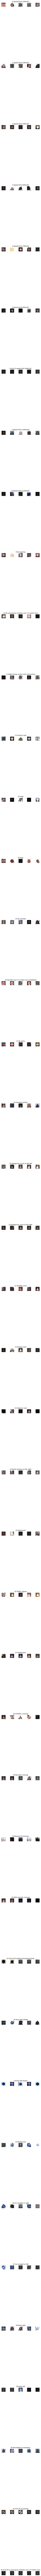

In [65]:
data = pd.read_csv(labelFile)
print("data shapes ", data.shape, type(data))

#Displaying Sample images of the classes
sample = []
cols = 5
num_classes = noofclasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        X_selected = X_train[y_train == j]
        axs[j][i].imshow(X_selected[random.randint(0, len(X_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+"-"+row["Name"])
            sample.append(len(X_selected))

# Displaying Graphs

[122, 1290, 1309, 799, 1109, 1094, 215, 788, 805, 829, 1149, 735, 1196, 1223, 450, 334, 245, 625, 716, 108, 191, 169, 213, 287, 137, 897, 351, 143, 323, 154, 254, 465, 138, 381, 234, 706, 188, 111, 1166, 174, 184, 126, 138]


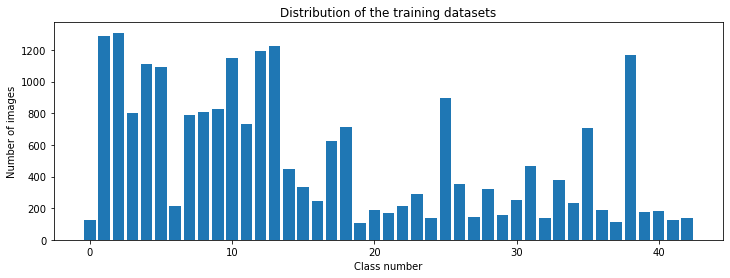

In [66]:
print(sample)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), sample)
plt.title("Distribution of the training datasets")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

# Processing Images

In [67]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train=np.array(list(map(preprocessing,X_train)))
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test = np. array(list(map(preprocessing,X_test)))
cv2.imshow("GrayScale images", X_train[random.randint(0,len(X_train)-1)])

In [68]:
## adding depth to the images
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [69]:
##Augmentation of the Images
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)
batches = dataGen.flow(X_train,y_train,batch_size=20)
X_batch, y_batch = next(batches)


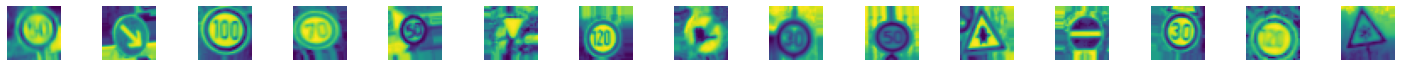

In [70]:
##Showing the Augmented Images
fig,axs = plt.subplots(1,15, figsize =(20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimension[0],imageDimension[1]))
    axs[i].axis('off')
plt.show()


# Applying CNN Model

In [72]:
def myModel():
    no_of_filters = 60
    size_of_filters = (5,5)

    size_of_filters2=(3,3)
    size_of_pool=(2,2)
    no_of_Nodes = 500
    model = Sequential()
    model.add((Conv2D(no_of_filters,size_of_filters,input_shape=(imageDimension[0],imageDimension[1],1),activation='relu')))
    model.add((Conv2D(no_of_filters,size_of_filters,activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))

    model.add((Conv2D(no_of_filters//2, size_of_filters2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_of_Nodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noofclasses,activation='softmax'))

    #Compile the model
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [76]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [77]:
model.fit(X_train,y_train,epochs = 5, validation_split = 0.1)

Epoch 1/5
627/627 [==============================] - 16s 22ms/step - loss: 7.4906 - accuracy: 0.0052 - val_loss: 7.0493 - val_accuracy: 0.0058
Epoch 2/5
627/627 [==============================] - 14s 22ms/step - loss: 7.0493 - accuracy: 0.0054 - val_loss: 7.0493 - val_accuracy: 0.0058
Epoch 3/5
627/627 [==============================] - 15s 25ms/step - loss: 7.0493 - accuracy: 0.0054 - val_loss: 7.0493 - val_accuracy: 0.0058
Epoch 4/5
627/627 [==============================] - 13s 21ms/step - loss: 7.0493 - accuracy: 0.0054 - val_loss: 7.0493 - val_accuracy: 0.0058
Epoch 5/5
627/627 [==============================] - 13s 21ms/step - loss: 7.0493 - accuracy: 0.0054 - val_loss: 7.0493 - val_accuracy: 0.0058
